# Compulsory 2 - Erlend Risvik

## Loading and preprocessing data 
Start by loading in the secret ID

In [1]:
import ast
import requests
import pandas as pd
from pyspark.sql import SparkSession
import os

SECRET_INFO = open("../NO_SYNC/weather_api", 'r').read().replace('\n', '')
SECRET_ID = ast.literal_eval(SECRET_INFO)["client_id"]

In CA1, we selected locality 12765.

Let's start by finding out the GPS coordinates of our locality

In [2]:
os.environ["PYSPARK_PYTHON"] = "python"

spark = SparkSession.builder.appName('SparkCassandraApp').\
    config('spark.jars.packages', 'com.datastax.spark:spark-cassandra-connector_2.12:3.4.1').\
    config('spark.cassandra.connection.host', 'localhost').\
    config('spark.sql.extensions', 'com.datastax.spark.connector.CassandraSparkExtensions').\
    config('spark.sql.catalog.mycatalog', 'com.datastax.spark.connector.datasource.CassandraCatalog').\
    config('spark.cassandra.connection.port', '9042').getOrCreate()

(spark.read.format("org.apache.spark.sql.cassandra")
 .options(table="fish_data_full", keyspace="compulsory")
 .load()
 .createOrReplaceTempView("fish_data_full"))

fish_data = spark.sql("select localityno, lon, lat, municipality, name from fish_data_full").toPandas()

In [3]:
# Select the GPS coordinates of locality 24175, and separate them by space
lat = round(fish_data.loc[fish_data['localityno'] == 24175, 'lat'].values[0], 3)
lon = round(fish_data.loc[fish_data['localityno'] == 24175, 'lon'].values[0], 3)
# Select the municipality and name of the same locality

municipality = fish_data.loc[fish_data['localityno'] == 24175, 'municipality'].values[0]
name = fish_data.loc[fish_data['localityno'] == 24175, 'name'].values[0]

# print lon, lat, municipality, name in f string nicely
print(f"Lon: {lon:.4f}\nLat: {lat:.4f}\nMunicipality: {municipality}\nPlace: {name}")

Lon: 17.2880
Lat: 69.4190
Municipality: Berg
Place: Ytre Lavollsfjord


In [41]:
endpoint = 'https://frost.met.no/sources/v0.jsonld'
parameters = {
"geometry" : f"nearest(POINT({lon} {lat}))",
"nearestmaxcount": 20,
}

# Issue an HTTP GET request
r = requests.get(endpoint, parameters, auth=(SECRET_ID,''))
# Extract JSON data
json = r.json()

# Check if the request worked, print out any errors
if r.status_code == 200:
    data = json['data']
    print('Data retrieved from frost.met.no!')
else:
    print('Error! Returned status code %s' % r.status_code)
    print('Message: %s' % json['error']['message'])
    print('Reason: %s' % json['error']['reason'])

Data retrieved from frost.met.no!


In [42]:
# Go through each json object in the data list, and print the shortname, id and distance
for item in data:
    print(f"Shortname: {item['shortName']}\nID: {item['id']}\nDistance: {item['distance']}\n")
    

Shortname: Steinfjord 
ID: SN88623
Distance: 5.40917897568

Shortname: Gryllefjord
ID: SN88500
Distance: 11.1811268141

Shortname: Senjahopen 
ID: SN88626
Distance: 11.79759797506

Shortname: FV862 Senjahopen
ID: SN88628
Distance: 12.42734046154

Shortname: Fv 7862 Kaperskaret
ID: SN88430
Distance: 13.54377269911

Shortname: Sifjord 
ID: SN88440
Distance: 15.78196906965

Shortname: Fjordgård 
ID: SN88630
Distance: 16.645800539299998

Shortname: MEDBY
ID: SN88450
Distance: 17.58548411876

Shortname: Husøy 
ID: SN88640
Distance: 20.53963725303

Shortname: BOTNHAMN
ID: SN88650
Distance: 24.51791028867

Shortname: Hekkingen fyr
ID: SN88690
Distance: 29.2291472994

Shortname: Laukhella
ID: SN88200
Distance: 31.60476668807

Shortname: Kistefjell
ID: SN89010
Distance: 35.96292952757

Shortname: FV84 Gumpen
ID: SN89213
Distance: 46.86965496929

Shortname: Andøya LH
ID: SN87110
Distance: 47.00479699996

Shortname: FV82 Kjølhågen
ID: SN87117
Distance: 51.634012020330005

Shortname: Skolten 
ID: 

Next, we select the data we want. Note that selecting the average of temperature does not make that much sense, but later in the exercise we aggregate by weekly averages, so it is not much loss of information.

In [50]:
# SN16610 contains the information needed
endpoint = 'https://frost.met.no/observations/v0.jsonld'
parameters = {
    'sources': 'SN87110',
    'elements': 'sum(precipitation_amount P1D), mean(air_temperature P1D), mean(wind_speed P1D), mean(relative_humidity P1D)',
    'referencetime': '2015-01-01/2015-12-31',
    'levels' : 'default',
    'timeoffsets': 'default'
}

# Issue an HTTP GET request
r = requests.get(endpoint, parameters, auth=(SECRET_ID,''))
# Extract JSON data
json = r.json()

In [44]:
# print lentgh of data
print(f"Length of data: {len(json['data'])}")


Length of data: 364


Now we convert the data to DataFrame.

In [51]:
df = pd.DataFrame()
data = json['data']
for i in range(len(data)):
    row = pd.DataFrame(data[i]['observations'])
    row['referenceTime'] = data[i]['referenceTime']
    row['sourceId'] = data[i]['sourceId']
    df = pd.concat([df, row], ignore_index=True)

df = df.reset_index(drop=True)

columns = ['sourceId','referenceTime','elementId','value','unit','timeOffset']
df2 = df[columns].copy()
df2['referenceTime'] = pd.to_datetime(df2['referenceTime']).dt.strftime('%Y-%m-%d')
df2.head()

,sourceId,referenceTime,elementId,value,unit,timeOffset
0,SN87110:0,2015-01-01,sum(precipitation_amount P1D),16.0,mm,PT6H
1,SN87110:0,2015-01-01,mean(air_temperature P1D),5.8,degC,PT0H
2,SN87110:0,2015-01-01,mean(wind_speed P1D),9.0,m/s,PT0H
3,SN87110:0,2015-01-01,mean(relative_humidity P1D),83.0,percent,PT0H
4,SN87110:0,2015-01-02,sum(precipitation_amount P1D),0.1,mm,PT6H


In [35]:
len(df2)

1088

In [52]:
# convert from wide to long format
df3 = df2.pivot(index='referenceTime', columns='elementId', values='value').reset_index()
# give better column names
df3.columns = ['date', 'temperature', 'humidity', 'wind_speed', 'precipitation']
df3.head()

,date,temperature,humidity,wind_speed,precipitation
0,2015-01-01,5.8,83.0,9.0,16.0
1,2015-01-02,3.0,80.0,6.5,0.1
2,2015-01-03,0.7,84.0,5.4,2.0
3,2015-01-04,0.3,86.0,7.1,5.0
4,2015-01-05,-1.5,74.0,9.6,2.3


In [53]:
# check for missing values
df3.isnull().sum()

date             0
temperature      0
humidity         0
wind_speed       0
precipitation    0
dtype: int64

Acceptable amount!

## Writing data to spark

In [11]:
from pyspark.sql import SparkSession
from cassandra.cluster import Cluster
import os

# Set pyspark env
os.environ["PYSPARK_PYTHON"] = "python"

spark = SparkSession.builder.appName('SparkCassandraApp').\
    config('spark.jars.packages', 'com.datastax.spark:spark-cassandra-connector_2.12:3.4.1').\
    config('spark.cassandra.connection.host', 'localhost').\
    config('spark.sql.extensions', 'com.datastax.spark.connector.CassandraSparkExtensions').\
    config('spark.sql.catalog.mycatalog', 'com.datastax.spark.connector.datasource.CassandraCatalog').\
    config('spark.cassandra.connection.port', '9042').getOrCreate()

# Connecting to Cassandra
cluster = Cluster(['localhost'], port=9042)
session = cluster.connect()
session.set_keyspace('compulsory')

def convert_to_spark(df):
    """Function to convert pandas dataframe to spark dataframe

    Parameters:
    -----------
    df : pandas dataframe
        Dataframe to convert

    Returns:
    --------
    spark dataframe
    """
    return spark.createDataFrame(df)

def list_tables():
    """
    Function to list all tables in cassandra
    """
    query = "SELECT * FROM system_schema.tables WHERE keyspace_name='compulsory';"
    rows = session.execute(query)
    for i in rows:
        print(i)

In [12]:
list_tables()

Row(keyspace_name='compulsory', table_name='car_table', additional_write_policy='99p', bloom_filter_fp_chance=0.01, caching=OrderedMapSerializedKey([('keys', 'ALL'), ('rows_per_partition', 'NONE')]), cdc=None, comment='', compaction=OrderedMapSerializedKey([('class', 'org.apache.cassandra.db.compaction.SizeTieredCompactionStrategy'), ('max_threshold', '32'), ('min_threshold', '4')]), compression=OrderedMapSerializedKey([('chunk_length_in_kb', '16'), ('class', 'org.apache.cassandra.io.compress.LZ4Compressor')]), crc_check_chance=1.0, dclocal_read_repair_chance=0.0, default_time_to_live=0, extensions=OrderedMapSerializedKey([]), flags=SortedSet(['compound']), gc_grace_seconds=864000, id=UUID('945dbc40-5954-11ee-8bb8-2f03669fdb2b'), max_index_interval=2048, memtable=None, memtable_flush_period_in_ms=0, min_index_interval=128, read_repair='BLOCKING', read_repair_chance=0.0, speculative_retry='99p')
Row(keyspace_name='compulsory', table_name='fish_data_full', additional_write_policy='99p', 

In [13]:
weather_spark = convert_to_spark(df3)
weather_spark.show()

In [15]:
# print length of weather_spark
print(f"Length of weather_spark: {weather_spark.count()}")

Length of weather_spark: 364


In [16]:
cassandra_types = {
    'temperature': 'float',
    'humidity': 'float',
    'wind_speed': 'float',
    'precipitation': 'float'
}

table_name = "weather_data"
cql_create_table = f"""
    CREATE TABLE IF NOT EXISTS {table_name} (
        date text PRIMARY KEY,
        {', '.join([f"{i} {cassandra_types[i]}" for i in weather_spark.columns if i != "date"])}
    );
""".replace("\n", " ")

session.execute(f"DROP TABLE IF EXISTS compulsory.{table_name};")
session.execute(cql_create_table)

In [17]:
(weather_spark
.write
.format("org.apache.spark.sql.cassandra")
.options(table=table_name, keyspace="compulsory")
.mode("append")
.save())

In [19]:
# shut down the connection
session.shutdown()
cluster.shutdown()

## Loading data from spark

In [20]:
from pyspark.sql import SparkSession
import pandas as pd
import os

os.environ["PYSPARK_PYTHON"] = "python"

spark = SparkSession.builder.appName('SparkCassandraApp').\
    config('spark.jars.packages', 'com.datastax.spark:spark-cassandra-connector_2.12:3.4.1').\
    config('spark.cassandra.connection.host', 'localhost').\
    config('spark.sql.extensions', 'com.datastax.spark.connector.CassandraSparkExtensions').\
    config('spark.sql.catalog.mycatalog', 'com.datastax.spark.connector.datasource.CassandraCatalog').\
    config('spark.cassandra.connection.port', '9042').getOrCreate()

# Reading the weather data from cassandra 
table_name = "weather_data"

(spark
.read
.format("org.apache.spark.sql.cassandra")
.options(table=table_name, keyspace="compulsory")
.load()
.createOrReplaceTempView(table_name))

weather_data = spark.sql(f"select * from {table_name}").toPandas()
weather_data.head()

,date,humidity,precipitation,temperature,wind_speed
0,2015-03-14,53.0,0.1,-2.5,1.8
1,2015-02-14,79.0,0.2,-4.4,1.6
2,2015-11-11,77.0,0.3,-0.1,3.4
3,2015-07-19,77.0,2.5,8.6,2.7
4,2015-09-22,84.0,1.8,5.1,3.5


In [21]:
# Sort values by date
weather_data['date'] = pd.to_datetime(weather_data['date'])

weather_data = weather_data.sort_values(by='date')
weather_data.head()

,date,humidity,precipitation,temperature,wind_speed
95,2015-01-01,76.0,0.1,0.9,5.7
233,2015-01-02,91.0,2.2,-3.1,6.7
102,2015-01-03,96.0,5.8,-6.3,4.4
269,2015-01-04,92.0,0.3,-7.4,4.3
323,2015-01-05,89.0,0.4,-4.7,1.5


In [22]:
table_name = "lice_data_full"

(spark
.read
.format("org.apache.spark.sql.cassandra")
.options(table=table_name, keyspace="compulsory")
.load()
.createOrReplaceTempView(table_name))

lice_data = spark.sql(f"select * from {table_name}").toPandas()
lice_data.head()

,id,avgadultfemalelice,avgmobilelice,avgstationarylice,hasbathtreatment,hascleanerfishdeployed,hasinfeedtreatment,hasmechanicalremoval,hasreportedlice,hassalmonoids,isfallow,isslaughterholdingcage,localityno,seatemperature,week,year
0,187281,0.00,0.02,0.13,False,False,False,False,True,True,False,False,24175,4.0,18,2015
1,187282,0.01,0.03,0.05,False,False,False,False,True,True,False,False,24175,4.5,19,2015
2,187301,0.06,0.32,0.88,False,True,False,False,True,True,False,False,24175,10.8,38,2015
3,187304,0.28,1.07,1.58,False,True,False,False,True,True,False,False,24175,9.2,41,2015
4,187293,0.00,0.01,0.11,False,False,False,False,True,True,False,False,24175,10.0,30,2015


In [23]:
lice_data = lice_data.sort_values(by='week')
lice_data.tail()

,id,avgadultfemalelice,avgmobilelice,avgstationarylice,hasbathtreatment,hascleanerfishdeployed,hasinfeedtreatment,hasmechanicalremoval,hasreportedlice,hassalmonoids,isfallow,isslaughterholdingcage,localityno,seatemperature,week,year
29,187311,0.04,0.05,1.14,False,True,False,False,True,True,False,False,24175,7.0,48,2015
5,187312,0.03,0.19,0.21,False,True,False,False,True,True,False,False,24175,6.5,49,2015
35,187313,0.03,0.13,0.30,False,True,False,False,True,True,False,False,24175,6.0,50,2015
26,187314,0.01,0.22,0.42,False,True,False,False,True,True,False,False,24175,5.0,51,2015
43,187315,0.04,0.15,0.21,False,True,False,False,True,True,False,False,24175,5.2,52,2015


In [24]:
# set week as index
lice_data = lice_data.set_index('week')
lice_data.head()

,id,avgadultfemalelice,avgmobilelice,avgstationarylice,hasbathtreatment,hascleanerfishdeployed,hasinfeedtreatment,hasmechanicalremoval,hasreportedlice,hassalmonoids,isfallow,isslaughterholdingcage,localityno,seatemperature,year
week,,,,,,,,,,,,,,,
1,187264,NaN,NaN,NaN,False,False,False,False,False,True,False,False,24175,5.3,2015
2,187265,0.0,0.0,0.0,False,False,False,False,True,True,False,False,24175,5.0,2015
3,187266,0.0,0.0,0.0,False,False,False,False,True,True,False,False,24175,4.5,2015
4,187267,0.0,0.0,0.0,False,False,False,False,True,True,False,False,24175,4.5,2015
5,187268,NaN,NaN,NaN,False,False,False,False,False,True,False,False,24175,3.7,2015


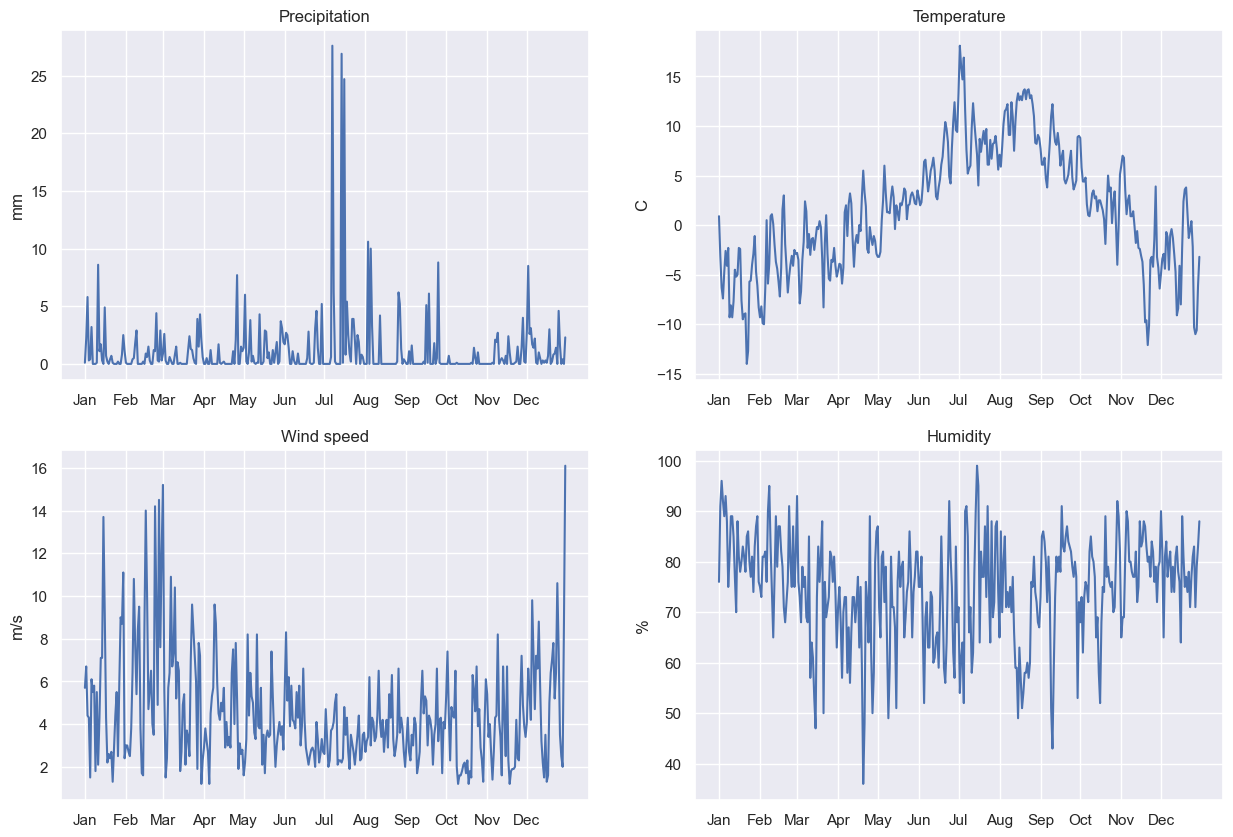

In [25]:
# plot the four variables
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

ticks = ['2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01', '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01', '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01']
labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

sns.lineplot(ax=axes[0, 0], data=weather_data, x='date', y='precipitation')
axes[0, 0].set_title('Precipitation')
axes[0, 0].set_xticks(ticks)
axes[0, 0].set_xticklabels(labels)
axes[0, 0].set_ylabel('mm')

sns.lineplot(ax=axes[0, 1], data=weather_data, x='date', y='temperature')
axes[0, 1].set_title('Temperature')
axes[0, 1].set_xticks(ticks)
axes[0, 1].set_xticklabels(labels)
axes[0, 1].set_ylabel('C')

sns.lineplot(ax=axes[1, 0], data=weather_data, x='date', y='wind_speed')
axes[1, 0].set_title('Wind speed')
axes[1, 0].set_xticks(ticks)
axes[1, 0].set_xticklabels(labels)
axes[1, 0].set_ylabel('m/s')

sns.lineplot(ax=axes[1, 1], data=weather_data, x='date', y='humidity')
axes[1, 1].set_title('Humidity')
axes[1, 1].set_xticks(ticks)
axes[1, 1].set_xticklabels(labels)
axes[1, 1].set_ylabel('%')

# hide the x label "date"
for ax in axes.flat:
    ax.set(xlabel='')

## Noise, outliers and pre-procecssing

We start by plotting the lice data to get a refersher of its properties.

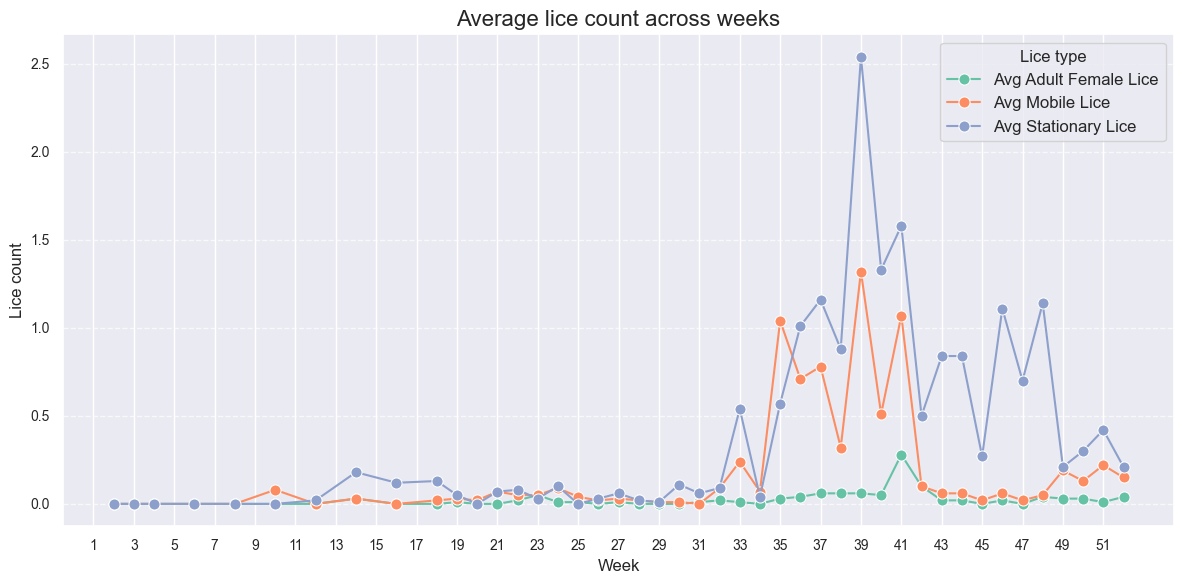

In [26]:
import numpy as np
custom_palette = sns.color_palette("Set2")

plt.figure(figsize=(12, 6))
sns.lineplot(x='week', y='avgadultfemalelice', data=lice_data, marker='o',\
              markersize=8, label='Avg Adult Female Lice', color=custom_palette[0])
sns.lineplot(x='week', y='avgmobilelice', data=lice_data, marker='o',\
              markersize=8, label='Avg Mobile Lice', color=custom_palette[1])
sns.lineplot(x='week', y='avgstationarylice', data=lice_data, marker='o',\
              markersize=8, label='Avg Stationary Lice', color=custom_palette[2])

plt.title('Average lice count across weeks', fontsize=16)
plt.xlabel('Week', fontsize=12)
plt.ylabel('Lice count', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xticks(np.arange(1, 53, 2))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Lice type', fontsize=12)
plt.tight_layout()

plt.show()

In [27]:
from scipy.signal import savgol_filter

# impute 0 where na
lice_data = lice_data.fillna(0)

# create a new dataframe "smoothed" with the week column as index. 
# Smooth using savgol filter.
smoothed = pd.DataFrame(index=lice_data.index)
y_smooth = savgol_filter(lice_data['avgadultfemalelice'].values, 5, 2)

smoothed['avgadultfemalelice_smooth'] = y_smooth
y_smooth = savgol_filter(lice_data['avgmobilelice'].values, 5, 3)

smoothed['avgmobilelice_smooth'] = y_smooth
y_smooth = savgol_filter(lice_data['avgstationarylice'].values, 7, 3)

smoothed['avgstationarylice_smooth'] = y_smooth

# merge the three original columns with the three smoothed columns into one dataframe on "week"
smoothed = pd.merge(lice_data[["avgadultfemalelice", "avgmobilelice", "avgstationarylice"]], smoothed, left_index=True, right_index=True)
smoothed.head()

,avgadultfemalelice,avgmobilelice,avgstationarylice,avgadultfemalelice_smooth,avgmobilelice_smooth,avgstationarylice_smooth
week,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
# Compute the robust means and robust covariance of the original data
import scipy.stats as stats
from sklearn.covariance import MinCovDet

# Compute regular mean and print
regular_means = lice_data[['avgadultfemalelice', 'avgmobilelice', 'avgstationarylice']].mean()
print(f"Regular means:\n{regular_means}")

# compute robust mean and print
robust_means = lice_data[['avgadultfemalelice', 'avgmobilelice', 'avgstationarylice']].apply(stats.trim_mean, axis=0, proportiontocut=0.05)
print(f"Robust means:\n{robust_means}")

# Compute regular covariance and print
cov = np.cov(lice_data[['avgadultfemalelice', 'avgmobilelice', 'avgstationarylice']].T)
print(f"Regular covariance:\n{cov}")

# Print robust covariance using MCD and print
mcd = MinCovDet(random_state=1).fit(lice_data[['avgadultfemalelice', 'avgmobilelice', 'avgstationarylice']])
mcd_mean = mcd.location_
mcd_cov = mcd.covariance_

print(f"Robust covariance:\n{mcd_cov}")

Regular means:
avgadultfemalelice    0.020577
avgmobilelice         0.149615
avgstationarylice     0.333654
dtype: float32
Robust means:
avgadultfemalelice    0.014375
avgmobilelice         0.112292
avgstationarylice     0.275625
dtype: float32
Regular covariance:
[[0.00182907 0.00811199 0.0133704 ]
 [0.00811199 0.08880377 0.12337594]
 [0.0133704  0.12337594 0.27282756]]
Robust covariance:
[[3.35067623e-05 9.07388147e-05 1.04058272e-04]
 [9.07388147e-05 8.53902212e-04 5.20707625e-04]
 [1.04058272e-04 5.20707625e-04 1.75109258e-03]]


The robust mean is slightly different, but the covariance is very different. 

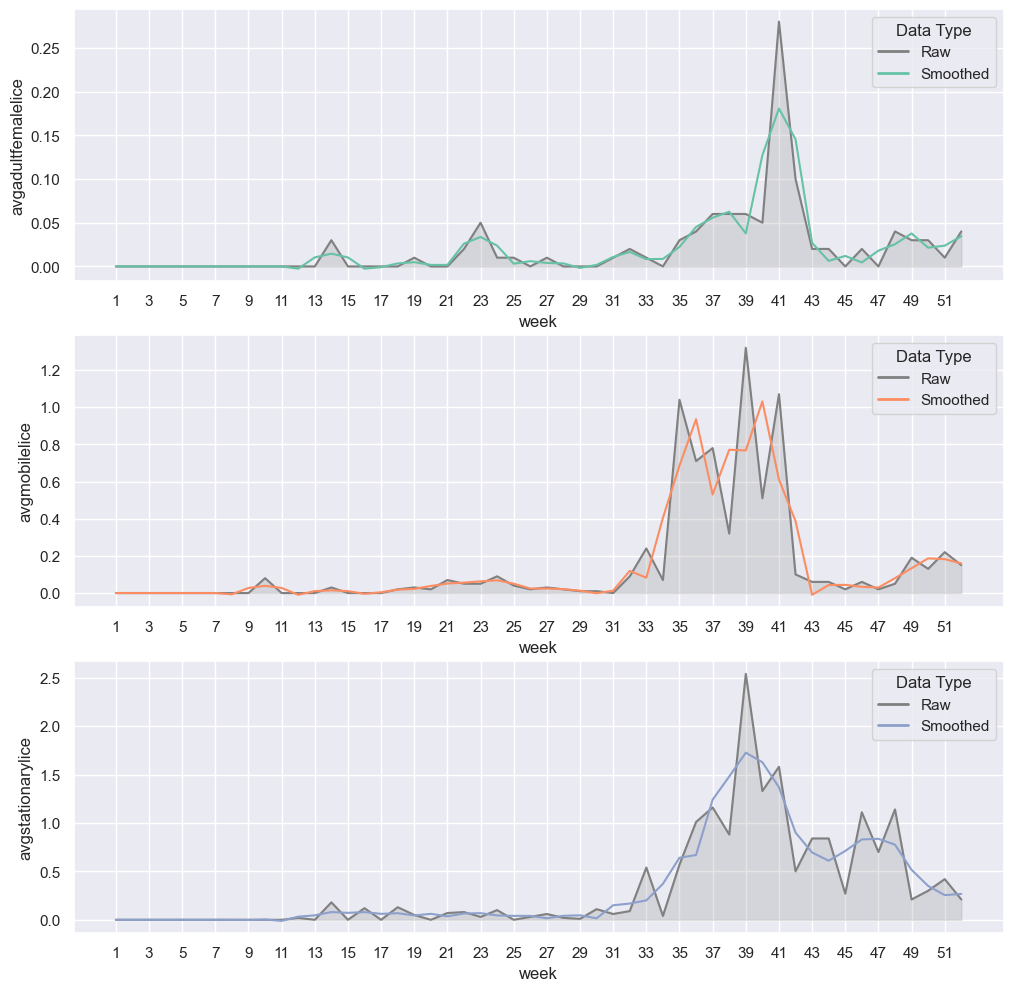

In [29]:
from matplotlib.lines import Line2D

# Plotting the smoothed series and raw series
custom_palette = sns.color_palette("Set2")

def legend_elements(ax):
    return [Line2D([0], [0], color='grey', lw=2, label='Raw'),
        Line2D([0], [0], color=custom_palette[ax], lw=2, label='Smoothed')]

# plotting the raw data as lineplot
fig, axes = plt.subplots(3, 1, figsize=(12, 12))
sns.lineplot(ax=axes[0], x='week', y='avgadultfemalelice', data=smoothed, color='grey')
sns.lineplot(ax=axes[1], x='week', y='avgmobilelice', data=smoothed, color='grey')
sns.lineplot(ax=axes[2], x='week', y='avgstationarylice', data=smoothed, color='grey')

# adding shadow
axes[0].fill_between(smoothed.index, smoothed['avgadultfemalelice'], color='grey', alpha=0.2)
axes[1].fill_between(smoothed.index, smoothed['avgmobilelice'], color='grey', alpha=0.2)
axes[2].fill_between(smoothed.index, smoothed['avgstationarylice'], color='grey', alpha=0.2)

# plotting the smoothed data
sns.lineplot(ax=axes[0], x='week', y='avgadultfemalelice_smooth', data=smoothed, color=custom_palette[0])
sns.lineplot(ax=axes[1], x='week', y='avgmobilelice_smooth', data=smoothed, color=custom_palette[1])
sns.lineplot(ax=axes[2], x='week', y='avgstationarylice_smooth', data=smoothed, color=custom_palette[2])

# adding legend
axes[0].legend(handles=legend_elements(0), title='Data Type')
axes[1].legend(handles=legend_elements(1), title='Data Type')
axes[2].legend(handles=legend_elements(2), title='Data Type')

# setting xticks
axes[0].set_xticks(np.arange(1, 53, 2));
axes[1].set_xticks(np.arange(1, 53, 2));
axes[2].set_xticks(np.arange(1, 53, 2));  


We can see that the smoothing attempts to average out the noise in the data. It is challenging to choose the hyperparameters for smoothing because we don't know if the peaks are noise or useful information. That is why i chose to use a smoothing method that is not too aggressive.

In [30]:
def Hotellings_T2(X, mean, cov, n, alpha = 0.01):
    T2 = np.sum(((X-mean) @ np.linalg.inv(cov)) * (X-mean), axis=-1)
    p = len(mean)
    F = (n-p)/(p*(n-1))*T2
    P = stats.f.sf(F, p, n-p)
    # Critical value
    c = stats.f.isf(alpha, p, n-p)*p*(n-1)/(n-p)
    return (T2, F, P, c)

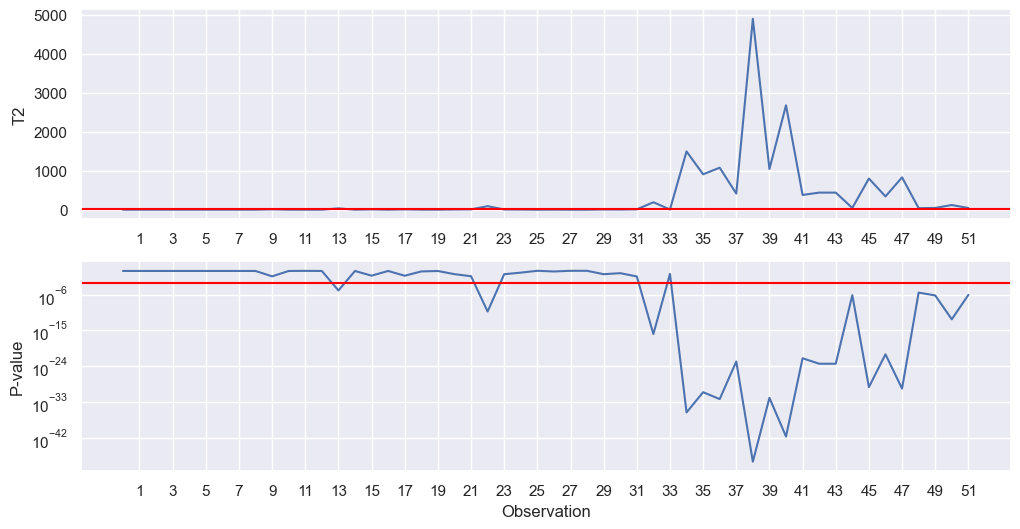

In [31]:
# Apply Hotellings_T2 and plotting
cols = ['avgadultfemalelice', 'avgmobilelice', 'avgstationarylice']
alpha = 0.001

# We use the robust mean and covariance to utilize the whole data
T2, F, P, c = Hotellings_T2(lice_data[cols].values, mcd_mean, mcd_cov, 52, alpha)
plt.figure(figsize=(12,6))
plt.subplot(211)
plt.plot(T2)
plt.grid(True)
plt.axhline(c, color="red")
plt.ylabel("T2")
plt.xticks(np.arange(1, 53, 2))
plt.subplot(212)

# Plot P on a logarithmic scale
plt.plot(P)
plt.yscale("log")
plt.grid(True)
plt.axhline(alpha, color="red")
plt.ylabel("P-value")
plt.xlabel("Observation")
plt.xticks(np.arange(1, 53, 2))
plt.show()

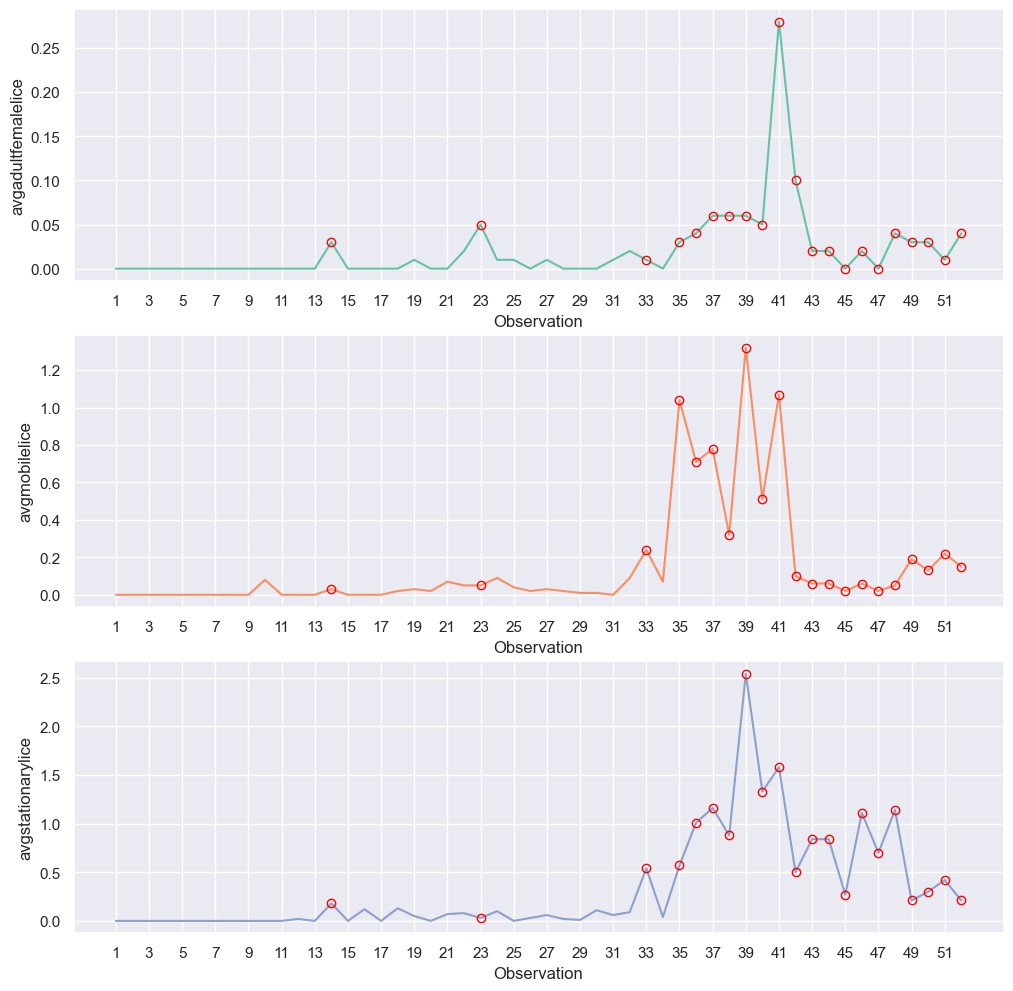

In [32]:
# Plotting the outliers as red circles
x = np.arange(1,53)+0.0
x[P>alpha] = np.nan

plt.figure(figsize=(12,12))
for col in range(len(cols)):
    plt.subplot(3, 1, col+1)
    plt.plot(smoothed[cols[col]], '-', color=custom_palette[col])
    plt.plot(x, smoothed[cols[col]], 'o', markeredgecolor='red', markerfacecolor='none')
    plt.ylabel(cols[col])
    plt.xlabel('Observation')
    plt.xticks(np.arange(1, 53, 2))
plt.show()

In [33]:
# Check how many observations are remaining
np.isnan(x).sum()

31

Because the covariance was so small, we mark a large majority of the samples as outliers. This occurs because most values in the dataset is 0, with some between 0 and 1, whereas after week 30-35 the data has spikes.

## Merging data and writing to spark

We merge the data as instructed. For aggregation, we use mean for everything but precipitation. This is because we used total accumulated precipitation for each day when selecting data from the weather API, and it also intuitively makes more sense.

In [34]:
# create a week column using the isocalendar method
weather_data['week'] = weather_data['date'].dt.isocalendar().week

# create the weekly_weather_data_mean DataFrame where we aggregate by weekly means
weekly_weather_data_mean = pd.DataFrame()
weekly_weather_data_mean['week'] = weather_data['week']
weekly_weather_data_mean['humidity'] = weather_data['humidity']
weekly_weather_data_mean['temperature'] = weather_data['temperature']
weekly_weather_data_mean['wind_speed'] = weather_data['wind_speed']
weekly_weather_data_mean = weekly_weather_data_mean.groupby('week').mean()

# same for precipitation, but we use weekly sum
weekly_weather_data_sum = pd.DataFrame()
weekly_weather_data_sum['week'] = weather_data['week']
weekly_weather_data_sum['precipitation'] = weather_data['precipitation']
weekly_weather_data_sum = weekly_weather_data_sum.groupby('week').sum()

# merging the two dataframes
weekly_weather_data = pd.merge(weekly_weather_data_mean, weekly_weather_data_sum, left_index=True, right_index=True)
weekly_weather_data.head()

,humidity,temperature,wind_speed,precipitation
week,,,,
1,88.750000,-3.975000,5.275000,8.400001
2,86.285713,-5.771429,4.042857,12.300000
3,79.857140,-4.957143,6.842857,8.900001
4,81.428574,-9.342857,3.114286,1.200000
5,80.714287,-5.200000,6.085714,4.700000


In [35]:
# join smoothed df and weekly_weather_data df on week 
complete_data = pd.merge(smoothed, weekly_weather_data, left_index=True, right_index=True)
complete_data.head()

,avgadultfemalelice,avgmobilelice,avgstationarylice,avgadultfemalelice_smooth,avgmobilelice_smooth,avgstationarylice_smooth,humidity,temperature,wind_speed,precipitation
week,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,88.750000,-3.975000,5.275000,8.400001
2,0.0,0.0,0.0,0.0,0.0,0.0,86.285713,-5.771429,4.042857,12.300000
3,0.0,0.0,0.0,0.0,0.0,0.0,79.857140,-4.957143,6.842857,8.900001
4,0.0,0.0,0.0,0.0,0.0,0.0,81.428574,-9.342857,3.114286,1.200000
5,0.0,0.0,0.0,0.0,0.0,0.0,80.714287,-5.200000,6.085714,4.700000


In [36]:
complete_data.tail()

,avgadultfemalelice,avgmobilelice,avgstationarylice,avgadultfemalelice_smooth,avgmobilelice_smooth,avgstationarylice_smooth,humidity,temperature,wind_speed,precipitation
week,,,,,,,,,,
48,0.04,0.05,1.14,0.025429,0.080000,0.775714,78.428574,-2.271429,4.300000,7.300000
49,0.03,0.19,0.21,0.037714,0.133429,0.515714,79.857140,-3.414286,5.828571,20.299999
50,0.03,0.13,0.30,0.021429,0.186571,0.349762,79.000000,-3.414286,5.500000,4.100000
51,0.01,0.22,0.42,0.023714,0.182286,0.254762,77.142860,-1.857143,3.757143,4.400000
52,0.04,0.15,0.21,0.034571,0.159429,0.267381,76.428574,-3.371429,6.214286,9.300000


In [37]:
from pyspark.sql import SparkSession
from cassandra.cluster import Cluster
import os

# Set pyspark env
os.environ["PYSPARK_PYTHON"] = "python"

spark = SparkSession.builder.appName('SparkCassandraApp').\
    config('spark.jars.packages', 'com.datastax.spark:spark-cassandra-connector_2.12:3.4.1').\
    config('spark.cassandra.connection.host', 'localhost').\
    config('spark.sql.extensions', 'com.datastax.spark.connector.CassandraSparkExtensions').\
    config('spark.sql.catalog.mycatalog', 'com.datastax.spark.connector.datasource.CassandraCatalog').\
    config('spark.cassandra.connection.port', '9042').getOrCreate()

# Connecting to Cassandra
cluster = Cluster(['localhost'], port=9042)
session = cluster.connect()
session.set_keyspace('compulsory')

def convert_to_spark(df):
    """Function to convert pandas dataframe to spark dataframe

    Parameters:
    -----------
    df : pandas dataframe
        Dataframe to convert

    Returns:
    --------
    spark dataframe
    """
    return spark.createDataFrame(df)

In [38]:
# set week as colmn from index due to technicalities
complete_data['week'] = complete_data.index
complete_data.head()

,avgadultfemalelice,avgmobilelice,avgstationarylice,avgadultfemalelice_smooth,avgmobilelice_smooth,avgstationarylice_smooth,humidity,temperature,wind_speed,precipitation,week
week,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,88.750000,-3.975000,5.275000,8.400001,1
2,0.0,0.0,0.0,0.0,0.0,0.0,86.285713,-5.771429,4.042857,12.300000,2
3,0.0,0.0,0.0,0.0,0.0,0.0,79.857140,-4.957143,6.842857,8.900001,3
4,0.0,0.0,0.0,0.0,0.0,0.0,81.428574,-9.342857,3.114286,1.200000,4
5,0.0,0.0,0.0,0.0,0.0,0.0,80.714287,-5.200000,6.085714,4.700000,5


In [39]:
lice_weather_spark = convert_to_spark(complete_data)
lice_weather_spark.show()

+--------------------+--------------------+--------------------+-------------------------+--------------------+------------------------+-----------------+-------------------+------------------+------------------+----+
|  avgadultfemalelice|       avgmobilelice|   avgstationarylice|avgadultfemalelice_smooth|avgmobilelice_smooth|avgstationarylice_smooth|         humidity|        temperature|        wind_speed|     precipitation|week|
+--------------------+--------------------+--------------------+-------------------------+--------------------+------------------------+-----------------+-------------------+------------------+------------------+----+
|                 0.0|                 0.0|                 0.0|                      0.0|                 0.0|                     0.0|            88.75|-3.9749999046325684| 5.275000095367432|  8.40000057220459|   1|
|                 0.0|                 0.0|                 0.0|                      0.0|                 0.0|                 

Next, we write this data to our database.

In [40]:
cassandra_types = {
    'temperature': 'float',
    'humidity': 'float',
    'wind_speed': 'float',
    'precipitation': 'float',
    'avgadultfemalelice': 'float',
    'avgmobilelice': 'float',
    'avgstationarylice': 'float',
    'avgadultfemalelice_smooth': 'float',
    'avgmobilelice_smooth': 'float',
    'avgstationarylice_smooth': 'float'
}

table_name = "lice_weather_data"
cql_create_table = f"""
    CREATE TABLE IF NOT EXISTS {table_name} (
        week int PRIMARY KEY,
        {', '.join([f"{i} {cassandra_types[i]}" for i in lice_weather_spark.columns if i != "week"])}
    );
""".replace("\n", " ")

session.execute(f"DROP TABLE IF EXISTS compulsory.{table_name};")
session.execute(cql_create_table)

In [41]:
(lice_weather_spark
.write
.format("org.apache.spark.sql.cassandra")
.options(table=table_name, keyspace="compulsory")
.mode("append")
.save())

## Test if loading data works

In [42]:
(spark
.read
.format("org.apache.spark.sql.cassandra")
.options(table=table_name, keyspace="compulsory")
.load()
.createOrReplaceTempView(table_name))

test = spark.sql(f"select * from {table_name}").toPandas().sort_values(by='week').reset_index(drop=True)
test.head()

,week,avgadultfemalelice,avgadultfemalelice_smooth,avgmobilelice,avgmobilelice_smooth,avgstationarylice,avgstationarylice_smooth,humidity,precipitation,temperature,wind_speed
0,1,0.0,0.0,0.0,0.0,0.0,0.0,88.750000,8.400001,-3.975000,5.275000
1,2,0.0,0.0,0.0,0.0,0.0,0.0,86.285713,12.300000,-5.771429,4.042857
2,3,0.0,0.0,0.0,0.0,0.0,0.0,79.857140,8.900001,-4.957143,6.842857
3,4,0.0,0.0,0.0,0.0,0.0,0.0,81.428574,1.200000,-9.342857,3.114286
4,5,0.0,0.0,0.0,0.0,0.0,0.0,80.714287,4.700000,-5.200000,6.085714


Looks great :)